In [1]:
%load_ext autoreload
%autoreload 2

import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

sns.set_style('whitegrid')

sys.path.append("../")
from utility.hmm1 import HMM1
from utility.hmmar1 import HMMAR1
from utility.hmmar1_gibbs import HMMAR1GibbsSampler

In [2]:
# Synthetic Data

# grouth truth
phi = 0.99
s = 1
v = s * (1 - phi**2)
w = s
hmm_sim = HMM1(phi, v, w_var=w)

# simulated series
np.random.seed(23502938)
df = hmm_sim.simulate(0, 1000)

In [3]:
# SOI Data
soi = pd.read_table("../data/soi.txt", names=['soi']).soi

In [4]:
# initialize
sampler = HMMAR1GibbsSampler(
    ys = soi.values,
    priors=HMMAR1GibbsSampler.Priors(
        mu0=0, mu_var=1,
        w0=0.8, w_ddof=5,
        phi0=0.5, phi_var=1, phi_bound=(0, 1),
        v0=0.2, v_ddof=5,
    ),
    seed=25352345
)

x0 = HMMAR1.LatentState(0, 1)

In [5]:
posterior_samples = sampler.sample_posterior(x0, n_samples=5000, burnin=1000)

In [6]:
samples = pd.DataFrame(map(lambda x: x[0], posterior_samples))
samples['s'] = samples.v / (1-samples.phi**2)
samples['snr'] = samples.wt / samples['s']

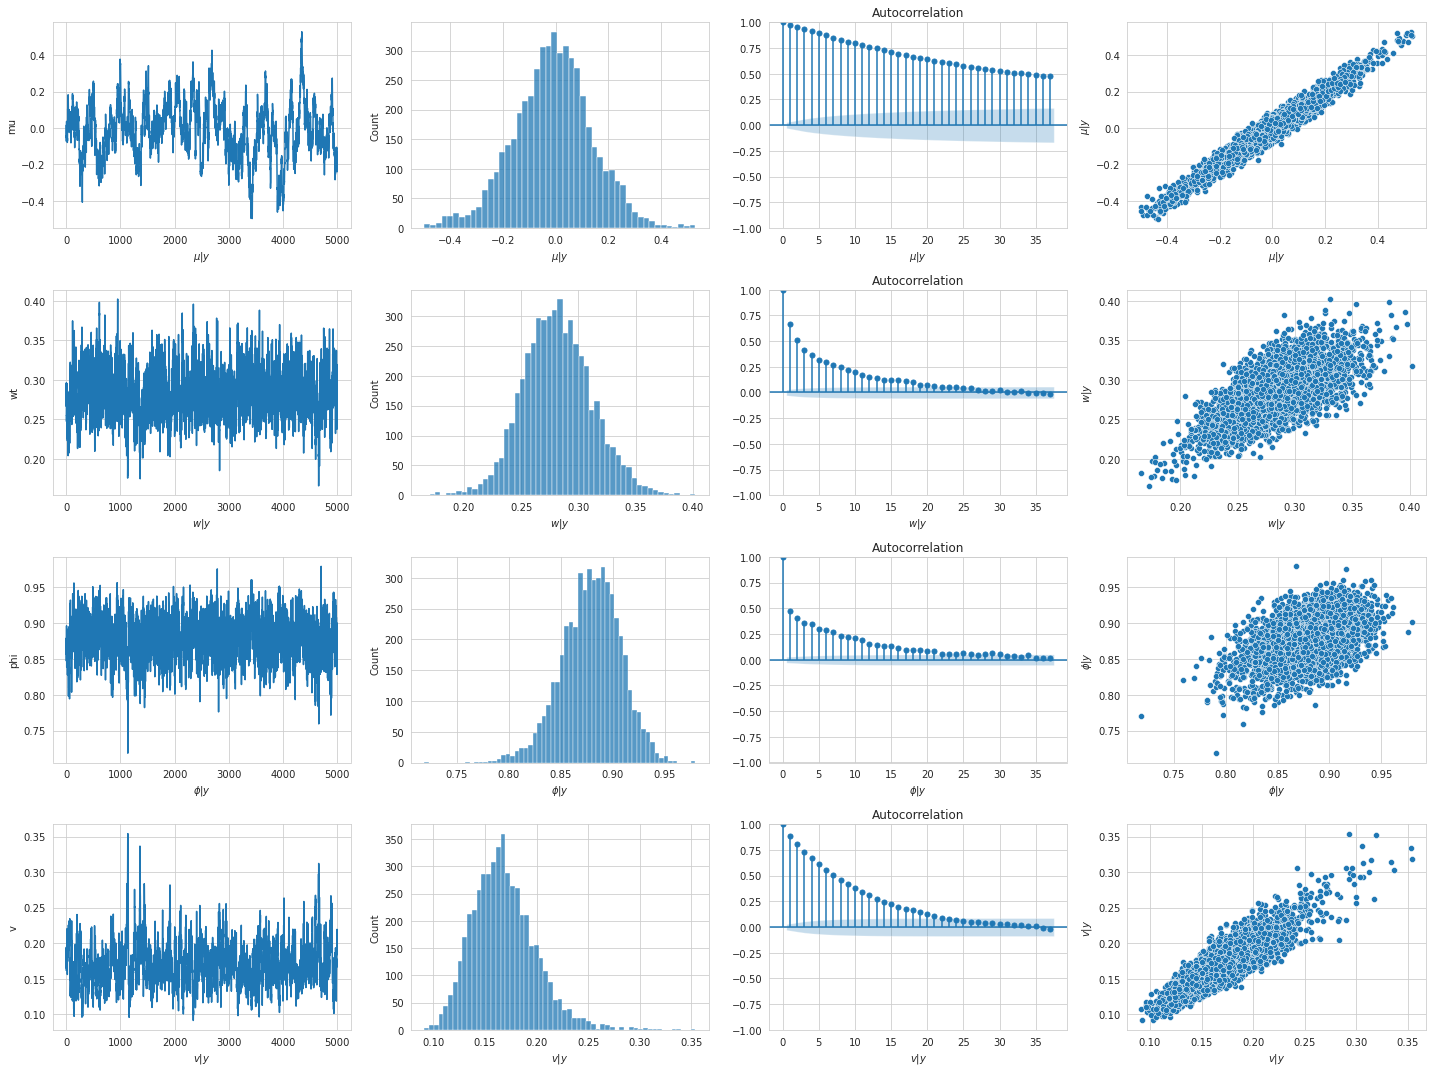

In [7]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))

sns.lineplot(samples.mu, ax=ax[0,0])
sns.histplot(samples.mu, ax=ax[0,1])
sm.graphics.tsa.plot_acf(samples.mu, ax=ax[0,2])
sns.scatterplot(x=samples.mu, y=samples.mu.shift(), ax=ax[0,3])
ax[0,0].set_xlabel('$\\mu|y$')
ax[0,1].set_xlabel('$\\mu|y$')
ax[0,2].set_xlabel('$\\mu|y$')
ax[0,3].set_xlabel('$\\mu|y$')
ax[0,3].set_ylabel('$\\mu|y$')

sns.lineplot(samples.wt, ax=ax[1,0])
sns.histplot(samples.wt, ax=ax[1,1])
sm.graphics.tsa.plot_acf(samples.wt, ax=ax[1,2])
sns.scatterplot(x=samples.wt, y=samples.wt.shift(), ax=ax[1,3])
ax[1,0].set_xlabel('$w|y$')
ax[1,1].set_xlabel('$w|y$')
ax[1,2].set_xlabel('$w|y$')
ax[1,3].set_xlabel('$w|y$')
ax[1,3].set_ylabel('$w|y$')

sns.lineplot(samples.phi, ax=ax[2,0])
sns.histplot(samples.phi, ax=ax[2,1])
sm.graphics.tsa.plot_acf(samples.phi, ax=ax[2,2])
sns.scatterplot(x=samples.phi, y=samples.phi.shift(), ax=ax[2,3])
ax[2,0].set_xlabel('$\\phi|y$')
ax[2,1].set_xlabel('$\\phi|y$')
ax[2,2].set_xlabel('$\\phi|y$')
ax[2,3].set_xlabel('$\\phi|y$')
ax[2,3].set_ylabel('$\\phi|y$')

sns.lineplot(samples.v, ax=ax[3,0])
sns.histplot(samples.v, ax=ax[3,1])
sm.graphics.tsa.plot_acf(samples.v, ax=ax[3,2])
sns.scatterplot(x=samples.v, y=samples.v.shift(), ax=ax[3,3])
ax[3,0].set_xlabel('$v|y$')
ax[3,1].set_xlabel('$v|y$')
ax[3,2].set_xlabel('$v|y$')
ax[3,3].set_xlabel('$v|y$')
ax[3,3].set_ylabel('$v|y$')

fig.tight_layout()
fig.show()

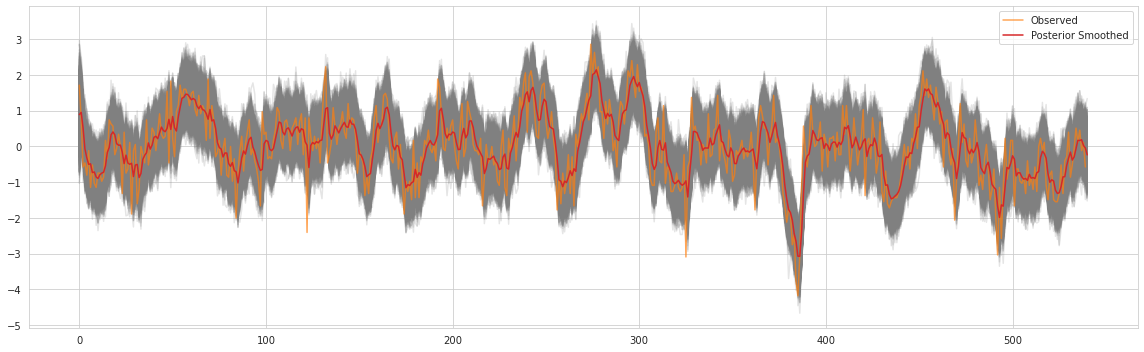

In [8]:
traces = np.array(list(map(lambda x: x[1], posterior_samples))).T

fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(traces, alpha=0.2, color='grey')
ax.plot(soi, alpha=0.7, color=sns.color_palette()[1], label='Observed')
ax.plot(traces.mean(1), color=sns.color_palette()[3], label='Posterior Smoothed')

ax.legend()
fig.tight_layout()
fig.show()